# 2. Exploratory data analysis (EDA)

In this notebook we will perform an exploratory data analysis (EDA) to grasp the underlying relationship among attributes after doing some feature transformation by regrouping categories. The present notebook contains the following sections: 

1. Importing packages and dataset
2. Feature transformation
3. Exploration of  associations among categorical variables
4. Pairwise exploration of correlation in selected variables 

## 2.1. Importing packages and dataset

In [1]:
# Import the required packages

import os
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Set visual style for plots
plt.style.use('seaborn')

We will import a ISO country code dataset that we will later use to regroup _Country_ attribute

In [3]:
# Import pre-processed dataset and load it into a dataframe

# Create path variables
file = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/interim/clean.csv'
country_codes = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/raw/ISO_country_code.csv'

# Load csv in dataframe
df = pd.read_csv(file, index_col=0)
countries_df = pd.read_csv(country_codes, index_col='alpha-3')

In [4]:
# Check # of columns and rows imported
df.shape, countries_df.shape

((78547, 38), (248, 1))

In [5]:
# Print info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78547 entries, 0 to 79329
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   78547 non-null  int64  
 1   LeadTime                     78547 non-null  float64
 2   ArrivalDateYear              78547 non-null  int64  
 3   ArrivalDateMonth             78547 non-null  object 
 4   ArrivalDateWeekNumber        78547 non-null  int64  
 5   ArrivalDateDayOfMonth        78547 non-null  int64  
 6   StaysInWeekendNights         78547 non-null  int64  
 7   StaysInWeekNights            78547 non-null  int64  
 8   Adults                       78547 non-null  float64
 9   Children                     78547 non-null  float64
 10  Babies                       78547 non-null  float64
 11  Meal                         78547 non-null  object 
 12  Country                      78547 non-null  object 
 13  MarketSegment   

---
## 2.2. Feature transformation

In this section, we will carry out a series of category regrouping in some features. The objective is to reduce the cardinality of the attributes, so when they will be transformed into numerical variables we do not end up with a highly sparse dataset.

Most of the variables are categorical so we cannot use a Pearson's correlation matrix to explore their relationsship. We will use Cramer's V algorithm to assess the association between categorical attributes.

In [6]:
# Checks number of 
df.nunique().sort_values(ascending=False)

ADR                            5367
ReservationDate                 888
ReservationStatusDate           864
CheckOutDate                    800
ArrivalDate                     793
LeadTime                        453
Agent                           223
Company                         203
Country                         163
DaysInWaitingList               114
PreviousBookingsNotCanceled      73
ArrivalDateWeekNumber            53
TotalStay                        34
ArrivalDateDayOfMonth            31
StaysInWeekNights                26
BookingChanges                   18
ReservationMonth                 12
StaysInWeekendNights             12
ArrivalDateMonth                 12
PreviousCancellations            10
AssignedRoomType                  8
MarketSegment                     7
ReservedRoomType                  7
TotalOfSpecialRequests            6
Adults                            5
DistributionChannel               4
Meal                              4
Children                    

In the cell below we will group by _Region_ instead of _Country_ of origin, so we can reduce the variable cardinality from 163 to 10.

In [7]:
# Changes values in for most common origin countries
countries_df.loc['PRT'] = 'National'
countries_df.loc['FRA'] = 'France'
countries_df.loc['DEU'] = 'Germany'
countries_df.loc['GBR'] = 'United_Kingdom'
countries_df.loc['ESP'] = 'Spain'

# Converts country codes in a dict
countries_dict = countries_df.to_dict()['region']

# Regroup Country attribute in fewer categories
df['Country'].replace(countries_dict, inplace=True)

In [8]:
# Checks for resulting changes
df['Country'].value_counts()

National          30851
Other_Europe      14848
France             8790
Germany            6080
United_Kingdom     5306
Spain              4600
Other_Americas     3926
Other_Asia         2802
Other_Africa        940
Other_Oceania       404
Name: Country, dtype: int64

Now, we will regroup the rest of categorical and numerical variables:

In [9]:
# Regroups PreviousCancellations column in fewer categories
df['PreviousCancellations'] = pd.cut(df['PreviousCancellations'], bins=[-np.inf,0,1,np.inf], labels=['0', '1','2+'])

# Regroups PreviousBookingsNotCanceled column in fewer categories
df['PreviousBookingsNotCanceled'] = pd.cut(df['PreviousBookingsNotCanceled'], bins=[-np.inf,0,1,np.inf], labels=['0','1-2','3+'])

# Regroup Babies column into binary
df['RequiredCarParkingSpaces'].where(df.RequiredCarParkingSpaces==0, 1, inplace=True)

# Regroup Babies column into binary
df['Babies'].where(df.Babies==0, 1, inplace=True)

# Regroup Children column into binary
df['Children'].where(df.Children==0, 1, inplace=True)

# Regroup Agent column into less categories
# First step: Replace nan values with value 0
df['Agent'].fillna(0.0, inplace=True)
# Replace most common agents with code for better readability
conv = {0.0:'no_Agent', 9.0:'Agent_A', 1.0:'Agent_B', 14.0:'Agent_C', 7.0:'Agent_D', 6.0:'Agent_E'}
df['Agent'].replace(conv, inplace=True)
# Finally, group the rest of values in single category
df['Agent'] = df['Agent'].map(lambda x: str(x))
df['Agent'].where(df.Agent.str.contains('Agent'), 'other_Agent', inplace=True)

# Regroup Company column into less categories
# First step: Replace nan values with value 0
df['Company'].fillna(0.0, inplace=True)
# Replace most common companies with code for better readability
conv = {0.0:'no_Company', 40.0:'Company_A'}
df['Company'].replace(conv, inplace=True)
# Finally, group the rest of values in single category
df['Company'] = df['Company'].map(lambda x: str(x))
df['Company'].where(df.Company.str.contains('Company'), 'other_Company', inplace=True)

# Reduces number of categories in ReservedRoomType column
df['ReservedRoomType'] = df['ReservedRoomType'].map(lambda x: x.strip())
df['ReservedRoomType'].where((df.ReservedRoomType=='A') | (df.ReservedRoomType=='D'), 'Other', inplace=True)

# Reduces number of categories in TotalOfSpecialRequests column
df['TotalOfSpecialRequests'] = pd.cut(df['TotalOfSpecialRequests'], bins=[-np.inf,0,1,np.inf], labels=['0', '1','2+'])

# Reduces number of categories in TotalOfSpecialRequests column
df['BookingChanges'] = pd.cut(df['BookingChanges'], bins=[-np.inf,0,1,np.inf], labels=['0', '1','2+'])

# Reduces number of categories in TotalOfSpecialRequests column
df['StaysInWeekendNights'] = pd.cut(df['StaysInWeekendNights'], bins=[-np.inf,0,1,2,np.inf], labels=['0','1','2','3+'])

# Reduces number of categories in TotalOfSpecialRequests column
df['StaysInWeekNights'] = pd.cut(df['StaysInWeekNights'], bins=[-np.inf,0,1,2,3,4,5,np.inf], labels=['0','1','2','3','4','5','6+'])

In [10]:
# Converts all non float variables in categorical
df['DaysInWaitingList'] = df['DaysInWaitingList'].astype('float64')
cat_cols = df.select_dtypes(exclude='float64').columns
df[cat_cols] = df[cat_cols].astype('category')

# Convert variables to categorical
df['Adults'] = df['Adults'].astype('category')
df['Children'] = df['Children'].astype('category')
df['Babies'] = df['Babies'].astype('category')
df['Country'] = df['Country'].astype('category')

We will create copy of the original df to apply the categorical association analysis, so we can preserve some continuous numerical variables as they are in the original dataset. All variables in the copy dataset 'df_copy' will be transformed into categories. 

In [11]:
# List non relevant variables for the analysis
to_drop = ['ReservationDate', 'ReservationStatusDate', 'CheckOutDate', 
           'ArrivalDate', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 
           'ArrivalDateYear', 'AssignedRoomType']

# Removes features and creates new df for Cramer's V correlation analysis
df_copy = df.drop(to_drop, axis=1)

We will convert numerical variables into categories to apply the categorical association analysis.

In [12]:
# Converts numerical variables into categorical by binning the values in quantiles
df_copy['LeadTime'] = pd.qcut(df['LeadTime'], 10)
df_copy['ADR'] = pd.qcut(df['ADR'], 10)
df_copy['TotalStay'] = pd.cut(df['TotalStay'], bins=[0,1,2,3,4,5,6,7,8,np.inf], labels=['0','1','2','3','4','5','6','7','8+'])

# Converts into binary variable
df_copy['DaysInWaitingList'].where(df_copy.DaysInWaitingList==0, 1, inplace=True)
df_copy['DaysInWaitingList'] = df_copy['DaysInWaitingList'].astype('category')

---
## 2.3. Exploration of  associations among categorical variables

In this section, we will explore the relationship across features by examinating the Cramér's V correlation matrix.

Cramér's V (sometimes referred to as Cramér's phi) is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946

In [13]:
def cramers_v(x, y):
    '''calculate Cramers V statistic for categorial-categorial association'''
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [14]:
def cramers_matrix(data):
    '''Calculates Cramers V statistic matrix for a df. All variables must be categorical'''
    cols = data.columns
    idx = data.columns
    mat = pd.DataFrame()
    for i in cols:
        for j in idx:
            mat.loc[i,j] = cramers_v(data[i], data[j])
    return mat           

In [15]:
# Creates the correlation matrix using Cramer's V on the copy of the dataset
corr_matrix = cramers_matrix(df_copy)

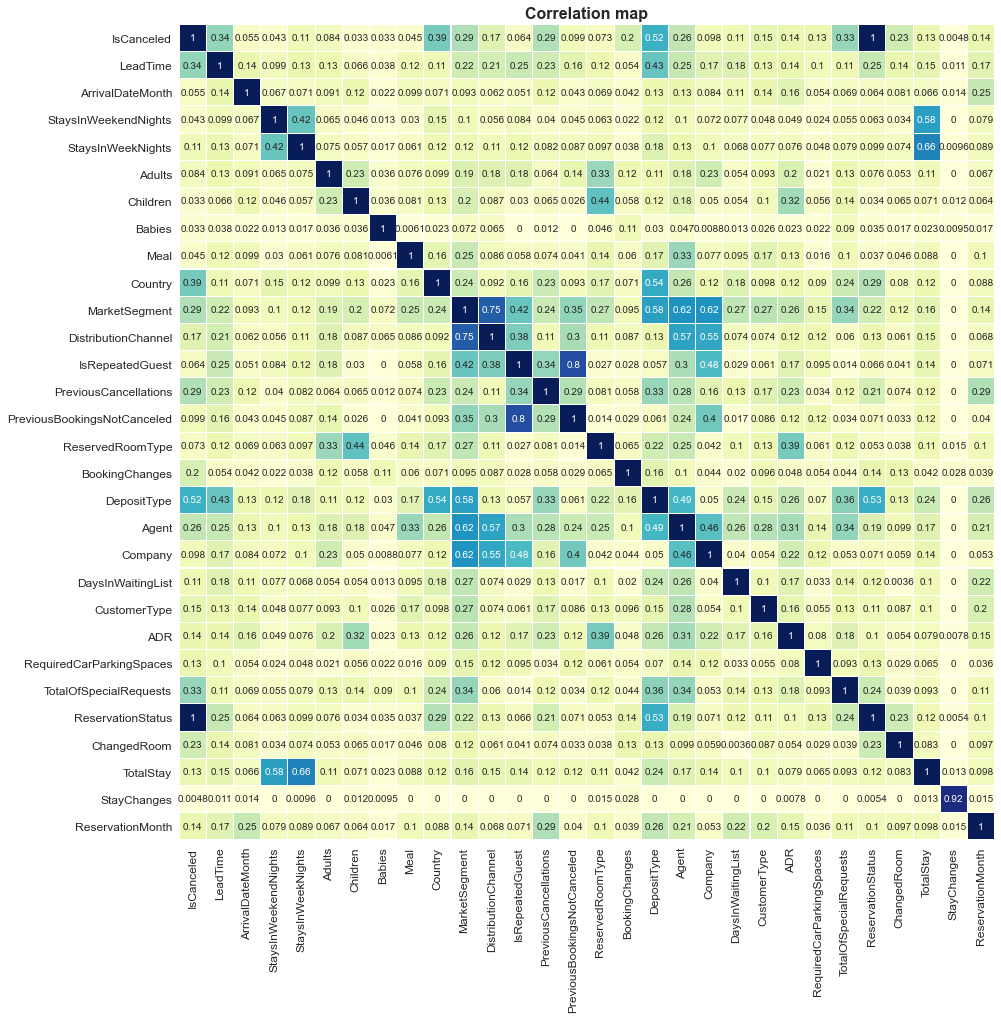

In [16]:
# Plot the correlation matrix with heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, cbar=False, square=True, linewidths=.05, ax=ax)
ax.set_title('Correlation map', weight='bold').set_fontsize('16')
ax.tick_params(labelsize=12)

plt.show()

We can see that there are some variables that are completely correlated and do not add any value: _ReservationStatus_ and _IsCancelled_

In [17]:
# Remove IsCancelled column
df.drop('IsCanceled', axis=1, inplace=True)

---
## 2.4. Pairwise exploration of correlation in selected variables

In this section, we will explore deeper the link between some variables with meaningful correlations seen in the Cramers's V association matrix. 

__Reservation channel vs. daily rates__

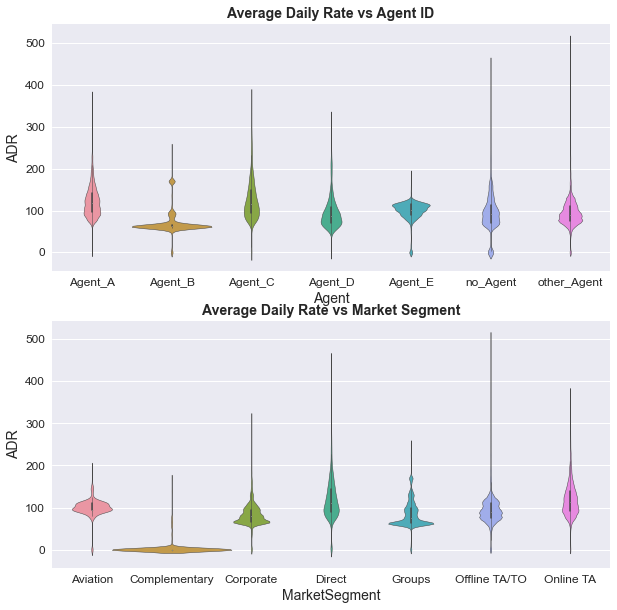

In [18]:
# Creates figure and two axes
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

# Creates plot on ax1
sns.violinplot(x=df['Agent'], y=df['ADR'], linewidth=0.5, width=1, ax=ax1)
ax1.set_title('Average Daily Rate vs Agent ID', weight='bold').set_fontsize('14')
ax1.tick_params(labelsize=12)
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)

# Creates plot on ax2
sns.violinplot(x=df['MarketSegment'], y=df['ADR'], linewidth=0.5, width=1.5, ax=ax2)
ax2.set_title('Average Daily Rate vs Market Segment', weight='bold').set_fontsize('14')
ax2.tick_params(labelsize=12)
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

plt.show()

We can see that reservations made through different agents had in general different average daily rates. For example, Agent B accounts for the distribution with the lower rates with median value of EUR 80, whereas Agent C had the bookings with the higher price range averaging ~EUR 100.  

Regarding Market Segment, it is clear that Corporate and Groups enjoyed the lower rates with roughly EUR 70 on average, in contrast with Online and Direct reservations which had EUR 100 rates on average.

__Reservation lead time vs. reservation status__

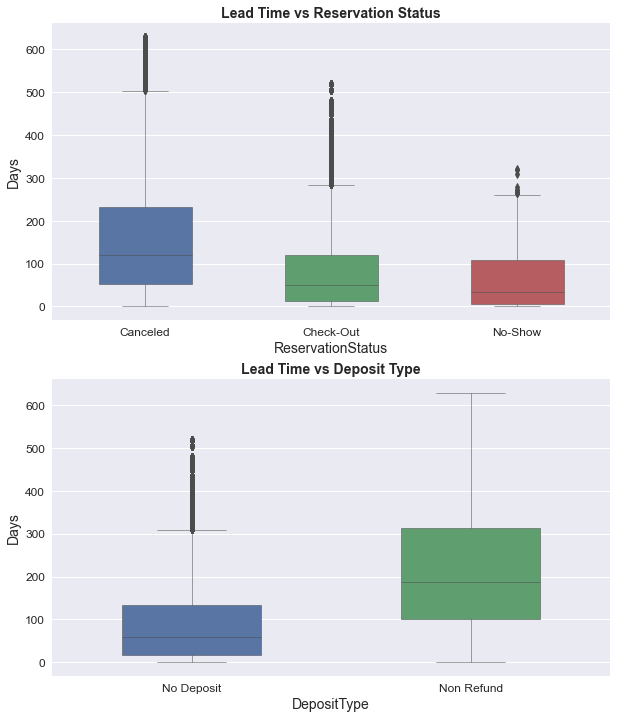

In [19]:
# Creates figure and two axes
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,12))

# Creates plot on ax1
sns.boxplot(x=df['ReservationStatus'], y=df['LeadTime'], linewidth=0.5, width=0.5, ax=ax1)
ax1.set_title('Lead Time vs Reservation Status', weight='bold').set_fontsize('14')
ax1.set_ylabel('Days')
ax1.tick_params(labelsize=12)
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)

# Creates plot on ax2
sns.boxplot(x=df['DepositType'], y=df['LeadTime'], linewidth=0.5, width=0.5, ax=ax2)
ax2.set_title('Lead Time vs Deposit Type', weight='bold').set_fontsize('14')
ax2.set_ylabel('Days')
ax2.tick_params(labelsize=12)
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

plt.show()

It can be seen that there is a positive relationship between bookings cancelled and lead time in days. Reservations made with more than 3 months in advance were more likely to be cancelled.

Also, it is clear and reasonable that for longer lead time periods are requested a non refundable deposit to make possible the reservation.

__Total stay vs. reservation deposit__

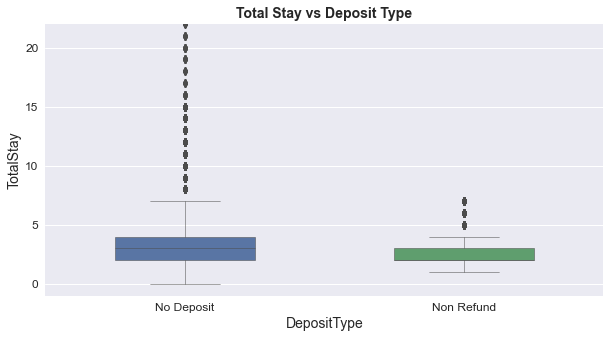

In [20]:
# Creates figure and two axes
fig, ax = plt.subplots(figsize=(10,5))

# Creates plot on ax
sns.boxplot(x=df['DepositType'], y=df['TotalStay'], linewidth=0.5, width=0.5, ax=ax)
ax.set_title('Total Stay vs Deposit Type', weight='bold').set_fontsize('14')
ax.set_ylim(-1,22)
ax.tick_params(labelsize=12)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.show()

We see that there is not a strong relationship between the length of stay and the deposit type, meaning that most likely the hotel does not request a deposit for long stays. 

---
The resulting dataframe is loaded in a csv file for further steps in a different notebook.

In [21]:
# Writing df dataframe to csv

path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-3/data/interim/category_transformation.csv'

df.to_csv(path)